# Asignación de tareas.

En el presente Notebook se presenta dos formas de asignar las tareas a
distintos agentes con el coste más bajo.

In [1]:
!pip install git+https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025.git


  Cloning https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025.git to /tmp/pip-req-build-mu56v4y8
  Running command git clone --filter=blob:none --quiet https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025.git /tmp/pip-req-build-mu56v4y8
  Resolved https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025.git to commit e7c3823c03994478ea3638506940db9edf615126
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# @title
import random
from heapq import heappush, heappop
from typing import Optional, Union, List, Set, Tuple
import time
from functools import wraps

import matplotlib.pyplot as plt

from MIAR03.beauty_printer import print_matrix

NumericTypes = Union[int, float]
SolutionType = Tuple[List[NumericTypes], NumericTypes]


def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.monotonic()
        result = func(*args, **kwargs)
        end_time = time.monotonic()
        elapsed_time = end_time - start_time
        if isinstance(result, tuple) and len(result) == 2 and isinstance(result[1], dict):
            result[1]["time"] = elapsed_time
            return result
        else:
            return result, {"time": elapsed_time}
    return wrapper


def generate_random_task_list(n: int, start: int = 1, stop: int = 100, seed: Optional[int] = None) -> List[List[int]]:
    if seed is not None:
        random.seed(seed)
    return [[random.randrange(start, stop) for _ in range(n)] for _ in range(n)]


class Node:
    def __init__(
            self,
            agent: int,
            task: Optional[int],
            cost: NumericTypes,
            parent: Optional['Node'] = None,
            lower_cost: int = 0
    ):
        self.agent = agent
        self.task = task
        self.parent = parent
        self.cost = cost
        self._accumulative_cost = \
            cost + (0 if self.parent is None else self.parent.accumulative_cost)
        self.lower_bound = self._accumulative_cost + lower_cost

    @property
    def accumulative_cost(self) -> NumericTypes:
        return self._accumulative_cost

    @property
    def satisfied_tasks(self) -> List[int]:
        tasks = []
        current = self
        while current:
            if current.task is not None:
                tasks.append(current.task)
            current = current.parent
        tasks.reverse()
        return tasks

    def __lt__(self, other: 'Node'):
        return self.lower_bound < other.lower_bound

    def __eq__(self, other: 'Node'):
        return self.lower_bound == other.lower_bound

    def __repr__(self):  # for logging purpose
        return f"satisfied:{self.satisfied_tasks}, single_cost: {self.cost}, cost:{self.lower_bound}"


In [3]:
COSTES = [
    #T0, T1, T2, T3
    [11, 12, 18, 40],  # A0
    [14, 15, 13, 22],  # A1
    [11, 17, 19, 23],  # A2
    [17, 14, 20, 28]   # A3
]

## Fuerza bruta pero aplicada de manera inteligente.

Este enfoque utiliza el criteria de Búsqueda de Costos Uniforme, se tomó
cierta inspiración en el algoritmo de Dijkstra.

Este algoritmo por cada iteración, tratará de encontrar la solución de menor
coste; sin embargo, en su proceso de ramificación, no existe control alguno,
lo cual existe la probabilidad de que explore casi todas las permutaciones.

Este algoritmo tiene complejidad $O(N!)$.

In [4]:
@measure_time
def ucs_solver(
        cost_matrix: List[List[int]],
        get_all_solutions: bool = False
) -> Union[List[SolutionType], SolutionType]:
    """
    Esta variante hace uso de Búsqueda de Costo Uniforme (UCS), hace una
    búsqueda por todos los nodos, y ramifica sin ningún tipo de verificación,
    lo cual lo hace de complejidad O(N!).\n
    Sirve para validar si la solución encontrada es la más corta.\n
    De manera más simple, esta es una variante de *fuerza bruta*, pero
    aplicada de manera inteligente.\n
    Es un algoritmo de exploración exhaustiva que prioriza los caminos más
    prometedores para evitar cálculos innecesarios.\n
    **Complejidad temporal**: *O(N!)*
    :param cost_matrix: Matriz de Costes
    :param get_all_solutions: Por defecto False,
    """
    agents = {i for i in range(len(cost_matrix))}
    tasks = {i for i in range(len(cost_matrix))}

    nodes: List[Node] = []
    [heappush(nodes, Node(0, i, cost_matrix[0][i], None)) for i in agents]
    solutions = []

    while nodes:
        current_node = heappop(nodes)
        satisfied_tasks = current_node.satisfied_tasks
        current_tasks = set(satisfied_tasks)
        available_tasks = tasks - current_tasks
        next_agent = current_node.agent + 1
        if len(current_node.satisfied_tasks) == len(agents):
            if not get_all_solutions:
                return satisfied_tasks, current_node.accumulative_cost
            solutions.append((satisfied_tasks, current_node.accumulative_cost))
            continue
        for task in available_tasks:
            child_node = Node(
                agent=next_agent,
                task=task,
                cost=cost_matrix[next_agent][task],
                parent=current_node
            )
            heappush(nodes, child_node)
    return solutions


In [5]:
solution_base_ucs, stats = ucs_solver(COSTES)
print(f"Solution: {solution_base_ucs}, time: {stats['time']}s")

Solution: ([0, 2, 3, 1], 61), time: 0.00020529099947452778s


## Ramificación y Poda

Este enfoque se pretende evitar ramificaciones que se intuyen o se sabe que
no van a cumplir el criterio del menor coste.

Para implementar una estrategia algo más inteligente, se usa de igual manera
una cola de prioridad para retornar aquellas respuestas aspirantes a solución
 de manera prioritaria siempre y cuando sean las de menor coste.

La definición del cálculo de la cota inferior se hace a partir de las tareas
que quedan pendientes por cada agente disponible y sin asignación de tareas.

In [6]:
def calculate_lower_cost(
        cost_matrix: List[List[NumericTypes]],
        next_agent: int,
        taken_tasks: Set[int]
) -> int:
    """
    Calcula la suma de los mínimos de las filas restantes, ignorando las
    tareas ya tomadas.

    :param cost_matrix: Matriz de costes
    :param next_agent: Agente desde el que se desea verificar los mínimos
    :param taken_tasks: Tareas ya asignadas previamente
    :return:
    """
    min_future_cost = 0
    num_agents = len(cost_matrix)

    for agent_idx in range(next_agent, num_agents):
        row_min = float('inf')
        for task_idx, cost in enumerate(cost_matrix[agent_idx]):
            if task_idx not in taken_tasks and cost < row_min:
                row_min = cost
        if row_min != float('inf'):
            min_future_cost += row_min

    return min_future_cost

El método `solver` permite bien sea iterar por todas las posibles ramas
candidatas a ser solución, para garantizar encontrar la solución más corta, o
 se puede forzar a que retorne la primera solución de menor costo disponible.

In [7]:
@measure_time
def solver(
        cost_matrix: List[List[int]],
        get_first_searched: bool = False
) -> SolutionType:
    nodes = []
    num_agents = len(cost_matrix)
    tasks = {i for i in range(len(cost_matrix))}
    best_cost = float('inf')

    root = Node(
        agent=-1, task=None, cost=0,
        lower_cost=calculate_lower_cost(cost_matrix, 0, set())
    )
    solution = None
    heappush(nodes, root)

    while nodes:
        current_node = heappop(nodes)

        if current_node.lower_bound >= best_cost:
            continue
        satisfied_tasks = current_node.satisfied_tasks

        if current_node.agent == num_agents - 1:  # if len(current_satisfied_tasks) == num_agents:
            if get_first_searched:
                return satisfied_tasks, current_node.accumulative_cost
            if current_node.accumulative_cost < best_cost:
                best_cost = current_node.accumulative_cost
                solution = (satisfied_tasks, current_node.accumulative_cost)
            continue
        current_tasks = set(satisfied_tasks)
        next_agent = current_node.agent + 1
        available_tasks = tasks - current_tasks

        for task in available_tasks:
            current_cost = cost_matrix[next_agent][task]
            current_accumulative_cost = current_node.accumulative_cost + current_cost
            if current_accumulative_cost >= best_cost:
                continue
            remain_tasks = current_tasks.union({task})
            lower_cost = calculate_lower_cost(cost_matrix, next_agent + 1,
                                              remain_tasks)
            child_node = Node(
                agent=next_agent,
                task=task,
                cost=current_cost,
                parent=current_node,
                lower_cost=lower_cost
            )
            if child_node.lower_bound < best_cost:
                heappush(nodes, child_node)

    return solution

In [8]:
solution_base_first, stats = solver(COSTES, True)
print(f"Solution: {solution_base_first}, time: {stats['time']}s")

solution_base_all_explored, stats = solver(COSTES, False)
print(f"Solution: {solution_base_all_explored}, time: {stats['time']}s")

Solution: ([0, 2, 3, 1], 61), time: 0.0006862050004201592s
Solution: ([0, 2, 3, 1], 61), time: 9.96489998215111e-05s


Se hará una prueba de matrices aleatorias con semilla definida, y hasta de 50x50

In [9]:
seed = None
timeout = 90

solvers_config = [
    {
        "name": "UCS",
        "func": ucs_solver,
        "args": [],
        "process_result": lambda x: x
    },
    {
        "name": "First Solution Pruned",
        "func": solver,
        "args": [True],
        "process_result": lambda x: x
    },
    {
        "name": "All Solution explored Pruned",
        "func": solver,
        "args": [],
        "process_result": lambda x: x
    }
]

execution_state = {
    conf["name"]: {"times": [], "active": True, "config": conf}
    for conf in solvers_config
}

for n in range(2, 50):

    if not any(state["active"] for state in execution_state.values()):
        print("\n--- Todos los algoritmos han superado el tiempo límite. Fin. ---")
        break

    print(f"\n--- {n}x{n} matrix ---")
    costs = generate_random_task_list(n, seed=seed)

    current_solutions = []

    for name, state in execution_state.items():
        if not state["active"]:
            continue
        conf = state["config"]

        raw_solution, stats = conf["func"](costs, *conf["args"])
        elapsed = stats['time']

        clean_solution = conf["process_result"](raw_solution)

        print(f"{name}: {clean_solution}, time: {elapsed}s")
        state["times"].append(elapsed)
        current_solutions.append(clean_solution)

        if elapsed >= timeout:
            print(f"⚠️  {name} excedió el timeout ({timeout}s) y se desactivará.")
            state["active"] = False

    if current_solutions:
        first_res = current_solutions[0]
        all_match_paths = all(res[0] == first_res[0] for res in current_solutions)
        all_match_costs = all(res[1] == first_res[1] for res in current_solutions)
    if current_solutions:
        first_res = current_solutions[0]
        all_match_paths = all(res[0] == first_res[0] for res in current_solutions)
        all_match_costs = all(res[1] == first_res[1] for res in current_solutions)
        if (not all_match_paths) and all_match_costs:
            print(f"⚠️  ¡Los resultados difieren entre los algoritmos a nivel de ruta!, pero mantienen el mismo coste\n")
        elif not all_match_costs:
             print("❌  ¡Los resultados difieren entre los algoritmos!\n")
        if not all_match_paths or not all_match_costs:
             print_matrix(costs, current_solutions[0][0], current_solutions[1][0], title=f"Costs: {[res[1] for res in current_solutions]}", width=4)


--- 2x2 matrix ---
UCS: ([0, 1], 74), time: 3.309200019430136e-05s
First Solution Pruned: ([0, 1], 74), time: 2.897200010920642e-05s
All Solution explored Pruned: ([0, 1], 74), time: 1.887700000224868e-05s

--- 3x3 matrix ---
UCS: ([0, 1, 2], 65), time: 0.0001446980004402576s
First Solution Pruned: ([0, 1, 2], 65), time: 3.3735000215529e-05s
All Solution explored Pruned: ([0, 1, 2], 65), time: 2.6700999114837032e-05s

--- 4x4 matrix ---
UCS: ([0, 3, 2, 1], 73), time: 5.042399970989209e-05s
First Solution Pruned: ([0, 3, 2, 1], 73), time: 4.447599985724082e-05s
All Solution explored Pruned: ([0, 3, 2, 1], 73), time: 4.214799992041662e-05s

--- 5x5 matrix ---
UCS: ([1, 2, 0, 4, 3], 82), time: 0.0001050769997164025s
First Solution Pruned: ([1, 2, 0, 4, 3], 82), time: 7.094600005075336e-05s
All Solution explored Pruned: ([1, 2, 0, 4, 3], 82), time: 6.922000011400087e-05s

--- 6x6 matrix ---
UCS: ([2, 0, 3, 1, 4, 5], 66), time: 0.00011064099999202881s
First Solution Pruned: ([2, 0, 3, 1, 4

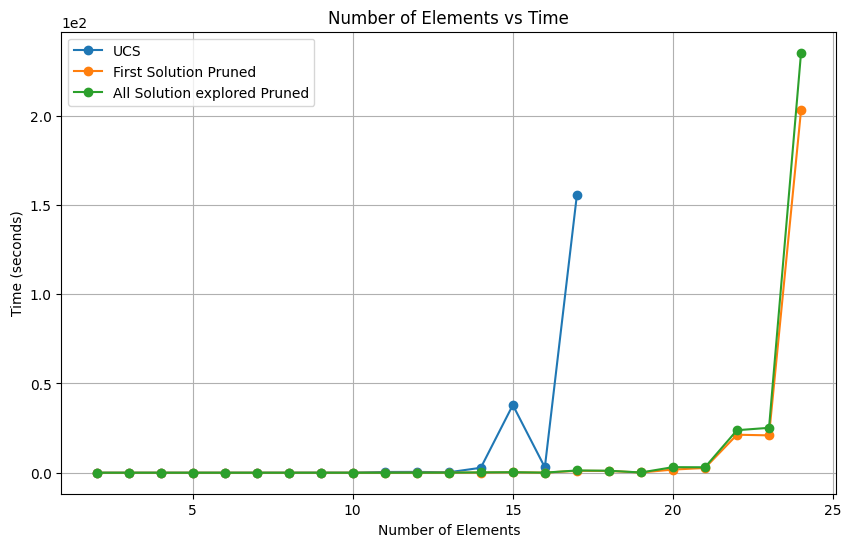

In [10]:
plt.figure(figsize=(10, 6))

for name, state in execution_state.items():
    times = state["times"]
    if not times: continue

    num_points = len(times)
    x_axis = range(2, 2 + num_points)

    plt.plot(x_axis, times, marker='o', label=name)

plt.title('Number of Elements vs Time')
plt.xlabel('Number of Elements')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

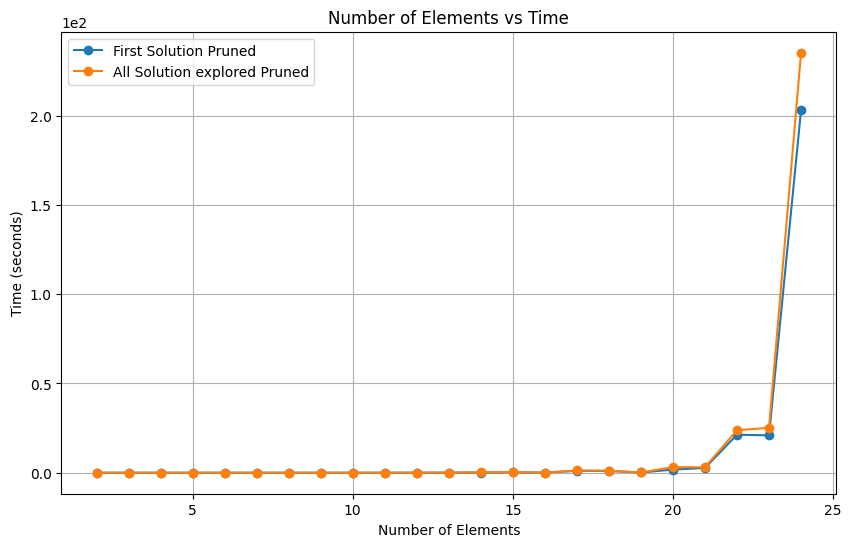

In [11]:
plt.figure(figsize=(10, 6))

for name, state in execution_state.items():
    if name == "UCS":
        continue
    times = state["times"]
    num_points = len(times)
    x_axis = range(2, 2 + num_points)

    plt.plot(x_axis, times, marker='o', label=name)

plt.title('Number of Elements vs Time')
plt.xlabel('Number of Elements')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()